In [1]:
# default_exp train.model

# Train 

> API details.

In [2]:
#hide
from nbdev.showdoc import *

import matplotlib.pyplot as plt

In [3]:
#export
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [4]:
#hide 
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.3.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
#export 
def load_data(path_processed_data):
    path_inputs = os.path.join(path_processed_data, 'input.npy')
    path_targets = os.path.join(path_processed_data, 'target.npy')

    inputs = np.load(path_inputs)
    targets = np.load(path_targets)

    inputs = inputs[:, :, :, :5]   # only considering geometric fields
    targets = targets*1e4   # sclaing plastic strain to more regular range

    inputs = inputs.astype('float32')
    targets = targets.astype('float32')

    return inputs, targets

In [16]:
#hide
path_processed_data = '../../examples/box_w_aggr/data/processed/'

inputs, targets = load_data(path_processed_data)

targets.dtype

dtype('float32')

In [17]:
#hide
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2, random_state=1)

inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape

((20, 400, 400, 5), (20, 400, 400, 1), (6, 400, 400, 5), (6, 400, 400, 1))

In [18]:
#hide
def make_dataset(inputs, targets, batch_size, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
    if is_train: dataset = dataset.shuffle(buffer_size=10)
    dataset = dataset.batch(batch_size)

    return dataset

In [48]:
dataset_train = make_dataset(inputs_train, targets_train, 4, is_train=True)
dataset_test = make_dataset(inputs_test, targets_test, 4)

In [20]:
#export
class GoogleNetLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', autocast=False, **kwargs):
        super(GoogleNetLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.conv1 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[0], **default_params)
        self.conv2 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[1], **default_params)
        self.conv3 = tf.keras.layers.Conv2D(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        c2 = self.conv1(inputs)
        c3 = self.conv1(inputs)
        return self.concat([c1, c2, c3])

In [21]:
#export
class GoogleNetTransposedLayer(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel_sizes, strides, name, dtype='float32', **kwargs):
        super(GoogleNetTransposedLayer, self).__init__(name=name, dtype=dtype, **kwargs)

        default_params = dict(filters=n_filters, strides=strides, padding='same', activation='relu')

        self.convt1 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[0], **default_params)
        self.convt2 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[1], **default_params)
        self.convt3 = tf.keras.layers.Conv2DTranspose(kernel_size=kernel_sizes[2], **default_params)
        self.concat = tf.keras.layers.Concatenate()
    
    def call(self, inputs):
        c1 = self.convt1(inputs)
        c2 = self.convt1(inputs)
        c3 = self.convt1(inputs)
        return self.concat([c1, c2, c3])

In [22]:
#export
class UnetModel(tf.keras.Model):
    def __init__(self, kernel_sizes, filter_sizes):
        super(UnetModel, self).__init__()
        self.d1_layer = GoogleNetLayer(filter_sizes[0], kernel_sizes, strides=(1,1), name='d1')
        self.d2_layer = GoogleNetLayer(filter_sizes[1], kernel_sizes, strides=(2,2), name='d2')
        self.d3_layer = GoogleNetLayer(filter_sizes[2], kernel_sizes, strides=(1,1), name='d3')
        self.d4_layer = GoogleNetLayer(filter_sizes[3], kernel_sizes, strides=(2,2), name='d4')

        self.u4_layer = GoogleNetTransposedLayer(filter_sizes[3], kernel_sizes, strides=(1,1), name='u4')
        self.u3_layer = GoogleNetTransposedLayer(filter_sizes[2], kernel_sizes, strides=(2,2), name='u3')
        self.u2_layer = GoogleNetTransposedLayer(filter_sizes[1], kernel_sizes, strides=(1,1), name='u2')
        self.u1_layer = GoogleNetTransposedLayer(filter_sizes[0], kernel_sizes, strides=(2,2), name='u1')

        self.u0_layer = tf.keras.layers.Conv2D(1, (1,1), activation='linear', padding='same', name='u1')

        self.concat1 = tf.keras.layers.Concatenate()
        self.concat3 = tf.keras.layers.Concatenate()

    def call(self, inputs):
        d1 = self.d1_layer(inputs)
        d2 = self.d2_layer(d1)
        d3 = self.d3_layer(d2)
        d4 = self.d4_layer(d3)

        u4 = self.u4_layer(d4)
        u3 = self.u3_layer(u4)
        c3 = self.concat3([u3, d3])
        u2 = self.u2_layer(c3)
        u1 = self.u1_layer(u2)
        c1 = self.concat1([u1, d1])

        return self.u0_layer(c1)

In [23]:
# export
def get_compiled_UnetModel(kernel_sizes, filter_sizes, input_shape):
    model = UnetModel(kernel_sizes, filter_sizes)
    model.build(input_shape)

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

In [88]:
#hide
kernel_sizes = [(7,7), (17,17), (21,21)]
filter_sizes = [4, 8, 16, 32]
input_shape = (None, 400, 400, 5)

initial_epoch = 0
history_all = []

model = get_compiled_UnetModel(kernel_sizes, filter_sizes, input_shape)

model.summary()

Model: "unet_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d1 (GoogleNetLayer)          multiple                  984       
_________________________________________________________________
d2 (GoogleNetLayer)          multiple                  4712      
_________________________________________________________________
d3 (GoogleNetLayer)          multiple                  18832     
_________________________________________________________________
d4 (GoogleNetLayer)          multiple                  75296     
_________________________________________________________________
u4 (GoogleNetTransposedLayer multiple                  150560    
_________________________________________________________________
u3 (GoogleNetTransposedLayer multiple                  75280     
_________________________________________________________________
u2 (GoogleNetTransposedLayer multiple                 

In [98]:
#hide
new_learning_rate = 1e-4

tf.keras.backend.set_value(model.optimizer.lr, new_learning_rate)

if len(history_all)>0: initial_epoch = history.epoch[-1] + 1

In [99]:
epochs = 200
validation_freq = 10

history = model.fit(
        dataset_train, 
        epochs=epochs,
        validation_data=dataset_test,
        validation_freq=validation_freq,
        initial_epoch=initial_epoch
    )

history_all.append(history)

Epoch 101/200
5/5 [==============================] - 5s 1s/step - loss: 0.0104 - mae: 0.0783
Epoch 102/200
5/5 [==============================] - 5s 1s/step - loss: 0.0100 - mae: 0.0764
Epoch 103/200
5/5 [==============================] - 5s 982ms/step - loss: 0.0098 - mae: 0.0757
Epoch 104/200
5/5 [==============================] - 5s 992ms/step - loss: 0.0096 - mae: 0.0749
Epoch 105/200
5/5 [==============================] - 5s 1s/step - loss: 0.0095 - mae: 0.0745
Epoch 106/200
5/5 [==============================] - 5s 1s/step - loss: 0.0094 - mae: 0.0742
Epoch 107/200
5/5 [==============================] - 7s 1s/step - loss: 0.0094 - mae: 0.0739
Epoch 108/200
5/5 [==============================] - 8s 2s/step - loss: 0.0093 - mae: 0.0738
Epoch 109/200
5/5 [==============================] - 8s 2s/step - loss: 0.0093 - mae: 0.0736
Epoch 110/200
5/5 [==============================] - 10s 2s/step - loss: 0.0093 - mae: 0.0736 - val_loss: 0.0106 - val_mae: 0.0792
Epoch 111/200
5/5 [=======

KeyboardInterrupt: 

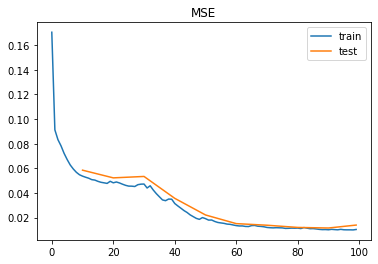

In [91]:
hist_loss_train = [loss_val for h in history_all for loss_val in h.history['loss']]
hist_loss_test = [loss_val for h in history_all for loss_val in h.history['val_loss']]

epochs_train = [e for h in history_all for e in h.epoch]
epochs_test = epochs_train[validation_freq::validation_freq] + [epochs_train[-1]]

plt.plot(epochs_train, hist_loss_train, label='train')
plt.plot(epochs_test, hist_loss_test, label='test')
plt.title('MSE')
plt.legend()

In [ ]:
#hide
model.save_weights('../models/model')

In [92]:
#export
def plot_example(target, pred):
    vmax = min(np.max(pred), np.max(target))
    vmin = 0

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
    ax0.imshow(np.squeeze(pred), vmin=vmin, vmax=vmax, cmap='seismic')
    ax0.set_title('prediction')

    im = ax1.imshow(np.squeeze(target), vmin=vmin, vmax=vmax, cmap='seismic')
    ax1.set_title('target')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax)

In [93]:
dataset = make_dataset(inputs_test, targets_test, 1)
pred = model.predict(dataset)

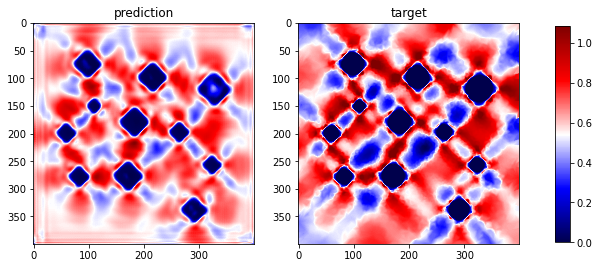

In [100]:
idx = 5
plot_example(targets_test[idx], pred[idx])